In [1]:
#%pip install pandas numpy matplotlib gym stable-baselines3 scikit-learn

In [2]:
#%pip install openpyxl

In [ ]:
#%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
import gymnasium as gym
import gymnasium.spaces as spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
file_path='OnlineRetail.xlsx'

In [5]:
def load_data(file_path):
    """
    Load UCI Online Retail dataset and keep only necessary columns.
    
    Args:
        file_path (str): Path to Excel file.
    
    Returns:
        pd.DataFrame: Filtered DataFrame with StockCode, UnitPrice, Quantity.
    """
    df = pd.read_excel(file_path)
    df = df[['StockCode', 'UnitPrice', 'Quantity']]
    df = df.dropna(subset=['StockCode', 'UnitPrice', 'Quantity'])
    df = df[df['UnitPrice'] > 0]
    df = df[df['Quantity'] > 0]
    return df

df=load_data(file_path)

In [6]:
df.shape

(530104, 3)

In [7]:
df.head()

,StockCode,UnitPrice,Quantity
0,85123A,2.55,6
1,71053,3.39,6
2,84406B,2.75,8
3,84029G,3.39,6
4,84029E,3.39,6


In [8]:
df.shape

(530104, 3)

In [9]:
df['StockCode'].value_counts()

StockCode
85123A    2265
85099B    2112
22423     2017
47566     1706
20725     1595
          ... 
47016        1
85049c       1
84550        1
47591b       1
23843        1
Name: count, Length: 3922, dtype: int64

In [10]:
df['StockCode'].nunique()

3922

In [11]:
# Filter out the top 15 most common StockCodes
top_stockcodes = df['StockCode'].value_counts().nlargest(2).index
df = df[df['StockCode'].isin(top_stockcodes)].copy()

In [12]:
df.shape

(4377, 3)

In [13]:
df['StockCode'].value_counts()

StockCode
85123A    2265
85099B    2112
Name: count, dtype: int64

In [23]:
class DynamicPricingEnv(gym.Env):
    def __init__(self, data, product_id, max_steps=100):
        super(DynamicPricingEnv, self).__init__()
        # Filter dataset for the specific StockCode
        self.data = data[data['StockCode'] == product_id].copy()
        if self.data.empty:
            raise ValueError(f"No data found for product {product_id}")
        
        # Normalize prices to range 0.5–1.5
        self.scaler = MinMaxScaler(feature_range=(0.5, 1.5))
        self.data['UnitPrice'] = self.scaler.fit_transform(self.data[['UnitPrice']])
        
        # Calculate average quantity for demand modeling
        self.avg_quantity = self.data['Quantity'].mean()
        
        # Define action space: 10 discrete price levels
        self.action_space = spaces.Discrete(10)
        
        # Define observation space: [normalized_price, purchase_probability]
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0]),
            high=np.array([2.0, 1.0]),
            dtype=np.float32
        )
        
        self.max_steps = max_steps
        self.current_step = 0
        self.current_price = 1.0
        self.purchase_prob = 0.5
        self.total_revenue = 0.0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.current_price = 1.0
        self.purchase_prob = 0.5
        self.total_revenue = 0.0
        obs = np.array([self.current_price, self.purchase_prob], dtype=np.float32)
        return obs, {}  # observation and empty info dict


    def step(self, action):
        # Map action (0–9) to price multiplier (0.5–1.5)
        price_multiplier = 0.5 + (action / 9.0) * 1.0
        self.current_price = price_multiplier

        # Calculate purchase probability
        price_factor = 0.5 * (self.current_price - 0.5)
        quantity_factor = self.avg_quantity / self.data['Quantity'].max()
        self.purchase_prob = max(0.1, 1.0 - price_factor + 0.1 * quantity_factor)

        # Simulate purchase
        purchase = np.random.random() < self.purchase_prob
        reward = self.current_price * self.avg_quantity * purchase
        self.total_revenue += reward

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False  # No early stop logic for now

        obs = np.array([self.current_price, self.purchase_prob], dtype=np.float32)
        info = {"revenue": self.total_revenue, "purchase_rate": self.purchase_prob}

        return obs, reward, terminated, truncated, info


    def render(self):
        # Print current state for debugging
        print(f"Step: {self.current_step}, Price: {self.current_price:.2f}, "
              f"Purchase Prob: {self.purchase_prob:.2f}, Total Revenue: {self.total_revenue:.2f}")


In [ ]:
models = {
    "DQN": (DQN, {
        "policy": "MlpPolicy",
        "learning_rate": 0.001,
        "buffer_size": 10000,
        "batch_size": 32
    }),
    "PPO": (PPO, {
        "policy": "MlpPolicy",
        "learning_rate": 0.0003,
        "n_steps": 2048,
        "batch_size": 64
    })
}


In [25]:
results = {}
stockcode_counts = df['StockCode'].value_counts().reset_index()
stockcode_counts.columns = ['StockCode', 'Count']

# Select the top 5 StockCodes by transaction count
top_stockcodes = stockcode_counts.head(5)

# Extract the list of top 5 StockCodes
selected_stockcodes = top_stockcodes['StockCode'].tolist()

# Display the top 5 StockCodes and their counts
print("\nTop 5 StockCodes by transaction count:")
print(top_stockcodes)
print(f"Selected StockCodes: {selected_stockcodes}")


Top 5 StockCodes by transaction count:
  StockCode  Count
0    85123A   2265
1    85099B   2112
Selected StockCodes: ['85123A', '85099B']


In [42]:
results = {}

# Loop through each StockCode in the top 5
for product_id in selected_stockcodes:
    print(f"\nProcessing StockCode: {product_id}")
    
    # Initialize environment for the current StockCode
    env = DynamicPricingEnv(df, product_id, max_steps=100)
    
    # Train, evaluate, and save each model (DQN, PPO)
    for model_name, (model_class, model_params) in models.items():
        print(f"Training {model_name} for {product_id}...")
        
        # Initialize and train the model
        model = model_class(**model_params, env=env, verbose=0)
        model.learn(total_timesteps=5000)  # Reduced timesteps for efficiency
        
        # Save the trained model
        model_path = f"Training/Saved Models/model_{model_name}_{product_id}.zip"
        model.save(model_path)
        print(f"Saved model to '{model_path}'")
        
        # Evaluate the model
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
        
        # Collect metrics during evaluation and render
        revenues = []
        purchase_rates = []
        actions_taken = []  # Track actions for optimal price
        optimal_prices = []  # To track the optimal price at each step

        obs, _ = env.reset()  # Gymnasium API: returns (obs, info)
        for step in range(env.max_steps):
            action, _ = model.predict(obs)
            actions_taken.append(action)  # Track action
            obs, reward, terminated, truncated, info = env.step(action)  # Gymnasium API: 5 return values
            done = terminated or truncated
            revenues.append(info['revenue'])
            purchase_rates.append(info['purchase_rate'])
            
            # Track the optimal price at each step
            most_common_action = np.bincount(actions_taken).argmax()
            optimal_price = 0.5 + (most_common_action / 9.0)
            optimal_prices.append(optimal_price)

            # Render every 10 steps
            if step % 10 == 0:
                env.render()
            
            if done:
                break

        # Store results with additional metadata
        results[f"{model_name}_{product_id}"] = {
            "stockcode": product_id,
            "model": model_name,
            "mean_reward": mean_reward,
            "std_reward": std_reward,
            "revenues": revenues,
            "purchase_rates": purchase_rates,
            "cumulative_revenue": np.sum(revenues),
            "average_purchase_rate": np.mean(purchase_rates),
            "model_path": model_path,
            "optimal_price": optimal_prices  # Added here to track price over time
        }



Processing StockCode: 85123A
Training DQN for 85123A...


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Saved model to 'Training/Saved Models/model_DQN_85123A.zip'


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Step: 1, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 23.09
Step: 11, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 161.65
Step: 21, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 287.28
Step: 31, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 402.74
Step: 41, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 564.39
Step: 51, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 633.67
Step: 61, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 864.60
Step: 71, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 933.88
Step: 81, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 1084.45
Step: 91, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 1210.07

Processing StockCode: 85099B
Training DQN for 85099B...


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Saved model to 'Training/Saved Models/model_DQN_85099B.zip'


c:\Users\athar\anaconda3\envs\rl-dps\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Step: 1, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 0.00
Step: 11, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 255.02
Step: 21, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 343.00
Step: 31, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 470.51
Step: 41, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 693.65
Step: 51, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 909.14
Step: 61, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 1116.98
Step: 71, Price: 1.06, Purchase Prob: 0.72, Total Revenue: 1364.35
Step: 81, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 1491.86
Step: 91, Price: 1.39, Purchase Prob: 0.56, Total Revenue: 1667.82


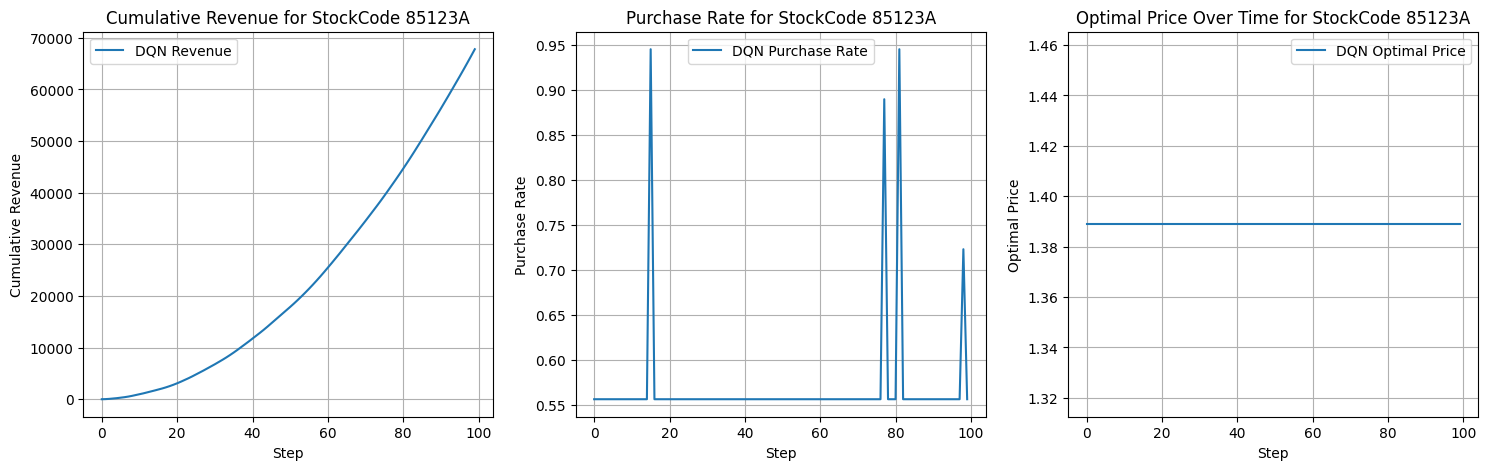

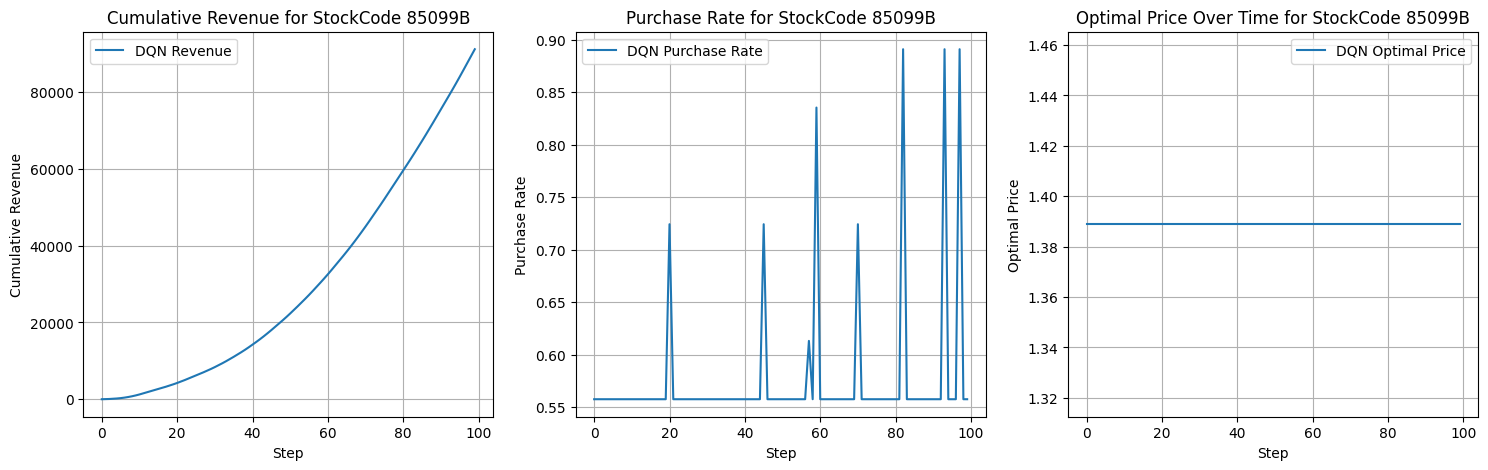

In [43]:
# Plot results for each StockCode
for product_id in selected_stockcodes:
    # Create a new figure for each StockCode
    plt.figure(figsize=(18, 5))  # Adjusted figure size for 3 subplots
    
    # Plot cumulative revenue
    plt.subplot(1, 3, 1)
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key in results:
            plt.plot(np.cumsum(results[key]["revenues"]), label=f"{model_name} Revenue")
    plt.title(f"Cumulative Revenue for StockCode {product_id}")
    plt.xlabel("Step")
    plt.ylabel("Cumulative Revenue")
    plt.legend()
    plt.grid(True)
    
    # Plot purchase rate
    plt.subplot(1, 3, 2)
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key in results:
            plt.plot(results[key]["purchase_rates"], label=f"{model_name} Purchase Rate")
    plt.title(f"Purchase Rate for StockCode {product_id}")
    plt.xlabel("Step")
    plt.ylabel("Purchase Rate")
    plt.legend()
    plt.grid(True)
    
    # Plot optimal price over time (ensure key is 'optimal_price' here)
    plt.subplot(1, 3, 3)
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key in results:
            plt.plot(results[key]["optimal_price"], label=f"{model_name} Optimal Price")  # Corrected key
    plt.title(f"Optimal Price Over Time for StockCode {product_id}")
    plt.xlabel("Step")
    plt.ylabel("Optimal Price")
    plt.legend()
    plt.grid(True)

    # # Save the figure
    # plt.tight_layout()
    # plt.savefig(f"dynamic_pricing_results_{product_id}.png")
    # plt.close()


In [ ]:
# Print evaluation metrics for each StockCode
print("\nAggregate Evaluation Metrics:")
for product_id in selected_stockcodes:
    print(f"\nStockCode: {product_id}")
    for model_name in models:
        key = f"{model_name}_{product_id}"
        if key in results:
            print(f"{model_name}:")
            print(f"  Mean Reward: {results[key]['mean_reward']:.2f} ± {results[key]['std_reward']:.2f}")
            print(f"  Final Cumulative Revenue: {np.sum(results[key]['revenues']):.2f}")
            print(f"  Average Purchase Rate: {np.mean(results[key]['purchase_rates']):.2f}")



Aggregate Evaluation Metrics:

StockCode: 85123A
DQN:
  Mean Reward: 1212.10 ± 84.36
  Final Cumulative Revenue: 55020.36
  Average Purchase Rate: 0.52

StockCode: 85099B
DQN:
  Mean Reward: 1778.76 ± 165.52
  Final Cumulative Revenue: 86862.00
  Average Purchase Rate: 0.57
